In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
import keras.backend as K
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from keras.utils.vis_utils import plot_model
import re

2024-04-26 20:45:16.403863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 20:45:17.602539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
hidden_dim = 2
batch_size = 60

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [21]:
def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def noiser(args):
    global mean, log_var
    mean, log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [22]:
# Encoder

input_image = Input(batch_shape=(batch_size, 28, 28, 1))
x = Flatten()(input_image)
x = Dense(256, activation="relu")(x)
x = dropout_and_batchnorm(x)
x = Dense(128, activation="relu")(x)
x = dropout_and_batchnorm(x)

In [23]:
# Latent Space
mean = Dense(hidden_dim)(x)
log_var = Dense(hidden_dim)(x)
h = Lambda(noiser, output_shape=(hidden_dim,), name="latent_space")([mean, log_var])

In [24]:
# Decoder
input_decoder = Input(shape=(hidden_dim,))

d = Dense(128, activation="relu")(input_decoder)
d = dropout_and_batchnorm(d)
d = Dense(256, activation="relu")(d)
d = dropout_and_batchnorm(d)
d = Dense(28*28, activation="sigmoid")(d)
decoded = Reshape((28, 28, 1))(d)

In [25]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)
    return loss + kl_loss 

In [26]:
encoder = keras.Model(input_image, h, name="encoder")
decoder = keras.Model(input_decoder, decoded, name="decoder")

vae = keras.Model(inputs = input_image, 
                   outputs = decoder(encoder(input_image)),
                   name="vae")

vae.compile(optimizer="adam", loss=vae_loss)

plot_model(encoder, to_file='encoderVAE_plot.png', show_shapes=True, show_layer_names=True)
plot_model(decoder, to_file='decoderVAE_plot.png', show_shapes=True, show_layer_names=True)

vae.summary()

Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(60, 28, 28, 1)]         0         
                                                                 
 encoder (Functional)        (60, 2)                   235908    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         236432    
                                                                 
Total params: 472,340
Trainable params: 470,804
Non-trainable params: 1,536
_________________________________________________________________


In [27]:
epochs = 25

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)

Epoch 1/25
1000/1000 [==============================] - 27s 20ms/step - loss: 62.9045
Epoch 2/25
1000/1000 [==============================] - 17s 17ms/step - loss: 44.8677
Epoch 3/25
1000/1000 [==============================] - 19s 19ms/step - loss: 43.7524
Epoch 4/25
1000/1000 [==============================] - 21s 21ms/step - loss: 43.1292
Epoch 5/25
1000/1000 [==============================] - 20s 20ms/step - loss: 42.6766
Epoch 6/25
1000/1000 [==============================] - 18s 18ms/step - loss: 42.4023
Epoch 7/25
1000/1000 [==============================] - 17s 17ms/step - loss: 42.1414
Epoch 8/25
1000/1000 [==============================] - 16s 16ms/step - loss: 41.9197
Epoch 9/25
1000/1000 [==============================] - 19s 19ms/step - loss: 41.7606
Epoch 10/25
1000/1000 [==============================] - 20s 20ms/step - loss: 41.5672
Epoch 11/25
1000/1000 [==============================] - 19s 19ms/step - loss: 41.4333
Epoch 12/25
1000/1000 [=============================

50/50 [==============================] - 0s 4ms/step


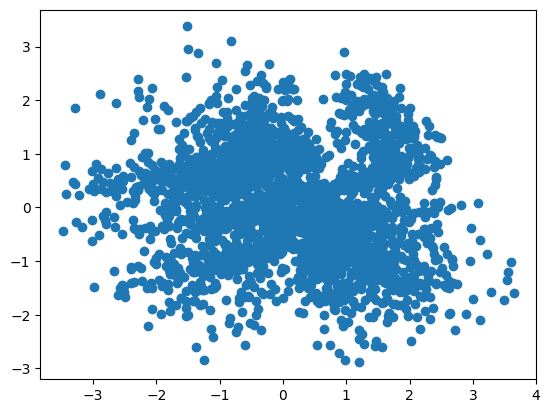

In [28]:
h = encoder.predict(x_test[:3000], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])
plt.show()

1/1 [==============================] - 0s 38ms/step


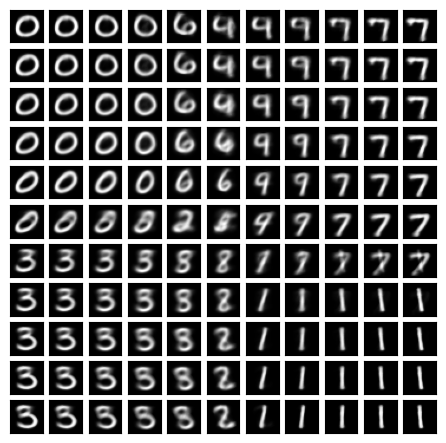

In [29]:
n =  5
size = 2*n+1

num = 1
plt.figure(figsize=(size/2, size/2))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(size, size, num)
        num += 1
        image = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(image.squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)